In [1]:
#import packages
import pandas as pd
import numpy as np
! pip install pmdarima
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/MyDrive/8_semestr/diplom/INTCshort.csv')

#print the head
df.head()
splitter=1450


     |████████████████████████████████| 1.5MB 5.1MB/s 
     |████████████████████████████████| 9.5MB 19.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


0      2021-06-07 04:00:00
1      2021-06-07 04:03:00
2      2021-06-07 04:04:00
3      2021-06-07 04:05:00
4      2021-06-07 04:06:00
               ...        
1583   2021-06-08 16:44:00
1584   2021-06-08 16:45:00
1585   2021-06-08 16:46:00
1586   2021-06-08 16:47:00
1587   2021-06-08 16:48:00
Name: Date, Length: 1588, dtype: datetime64[ns]


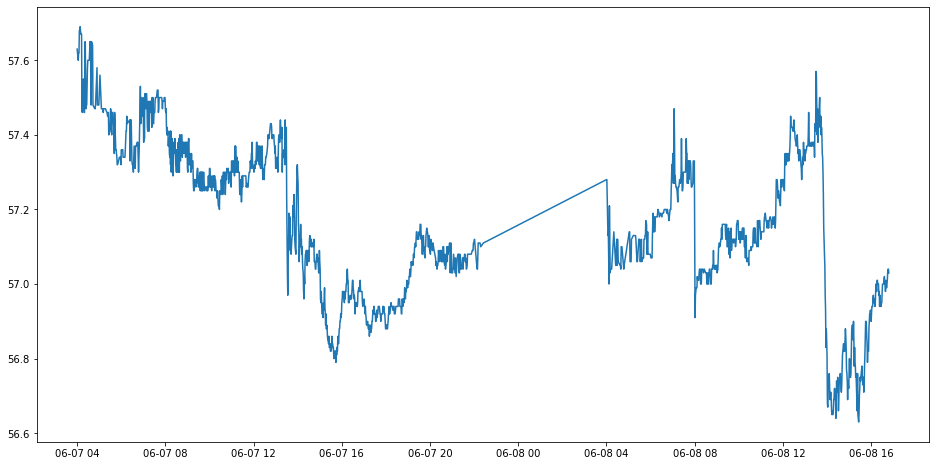

In [2]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%dT%H:%M:%SZ')
print(df.Date)
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [3]:
import pmdarima as pm

data = df.sort_index(ascending=True, axis=0)

train = data[:splitter]
valid = data[splitter:]

training = train['Close']
validation = valid['Close']

model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True,n_jobs=-1)
model.fit(training)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4441.583, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4905.592, Time=1.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-4562.771, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-5063.458, Time=3.51 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=16.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.09 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-4938.988, Time=3.00 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-5064.279, Time=4.44 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-4907.160, Time=2.05 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=42.48 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=8.73 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-5066.984, Time=5.66 sec
 ARIMA(3,1,0)(1,1,0)[12]             : 

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [4]:
forecast = model.predict(n_periods=len(data)-splitter)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [5]:
from sklearn.metrics import r2_score
print(r2_score(np.array(valid['Close']), np.array(forecast['Prediction'])))
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
# rms

-35.41536640169103


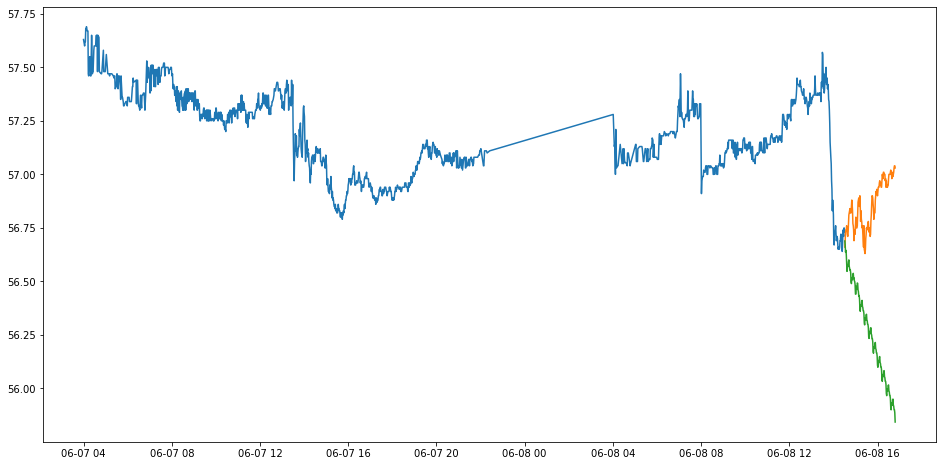

In [6]:
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [7]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%dT%H:%M:%SZ')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:splitter]
valid = new_data[splitter:]

#fit the model
model = Prophet(daily_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)
# print(train)
# print(forecast[['ds','yhat']].tail())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [8]:
#rmse
forecast_valid = forecast['yhat'][splitter:]
print(r2_score(np.array(valid['y']),np.array(forecast_valid)))
# rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
# rms

-29282165.96207156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



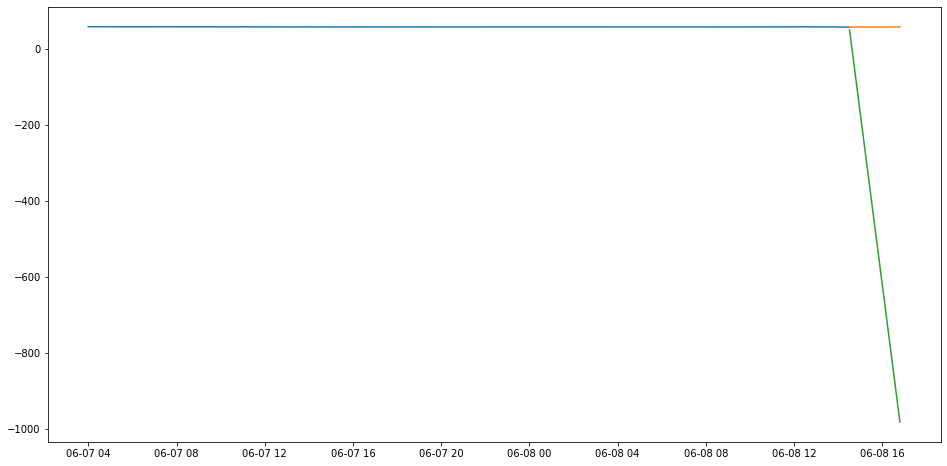

In [9]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.figure(figsize=(16,8))
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [10]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:splitter,:]
valid = dataset[splitter:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs = 100, batch_size = 150)
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(LSTM(units=50))
# model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


Epoch 1/100
10/10 [==============================] - 27s 20ms/step - loss: 0.1546
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0256
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0169
Epoch 4/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0116
Epoch 5/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0101
Epoch 6/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0088
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0087
Epoch 8/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0081
Epoch 9/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0078
Epoch 10/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0076
Epoch 11/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0072
Epoch 12/100
10/10 [==============================] - 0s 19ms/step - loss: 0.0078
Epoch 13/100
10/10 [====

In [11]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
# print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)


[[[0.87735849]
  [0.79245283]
  [0.72641509]
  ...
  [0.0754717 ]
  [0.11320755]
  [0.09433962]]

 [[0.79245283]
  [0.72641509]
  [0.79245283]
  ...
  [0.11320755]
  [0.09433962]
  [0.02830189]]

 [[0.72641509]
  [0.79245283]
  [0.70754717]
  ...
  [0.09433962]
  [0.02830189]
  [0.05660377]]

 ...

 [[0.25471698]
  [0.24528302]
  [0.21698113]
  ...
  [0.3490566 ]
  [0.35849057]
  [0.37735849]]

 [[0.24528302]
  [0.21698113]
  [0.19811321]
  ...
  [0.35849057]
  [0.37735849]
  [0.38679245]]

 [[0.21698113]
  [0.19811321]
  [0.1509434 ]
  ...
  [0.37735849]
  [0.38679245]
  [0.38679245]]]


In [12]:
closing_price = model.predict(X_test)
print(closing_price.shape)
closing_price = scaler.inverse_transform(closing_price)

(138, 1)


In [13]:
print(r2_score(valid,closing_price))
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.23235916546980095


0.09773611290575357

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



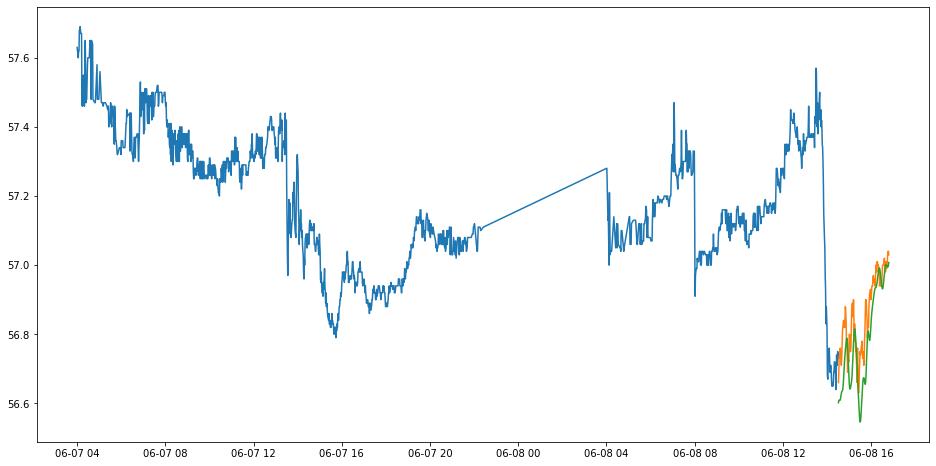

In [14]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [15]:
from keras.layers import GRU
from keras.optimizers import SGD

my_GRU_model = Sequential()
# First GRU layer with Dropout regularisation
my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Second GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))

# Third GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Fourth GRU layer
my_GRU_model.add(GRU(units=50, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# The output layer
my_GRU_model.add(Dense(units=1))
# Compiling the RNN
my_GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
my_GRU_model.fit(x_train,y_train,epochs=100,batch_size=150, verbose=1)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predictions = my_GRU_model.predict(X_test)
GRU_predictions = scaler.inverse_transform(GRU_predictions)

Epoch 1/100
10/10 [==============================] - 8s 27ms/step - loss: 0.1356
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0402
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0265
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0225
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0181
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0148
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0117
Epoch 8/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0085
Epoch 9/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0073
Epoch 10/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0054
Epoch 11/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0045
Epoch 12/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0050
Epoch 13/100
10/10 [=====

In [16]:
# print(GRU_predictions)
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], GRU_predictions, squared=False)
print(r2_score(valid["Close"],GRU_predictions))
# print(rms)
# print(GRU_predictions[100:])
# print(valid)
# print(GRU_predictions.shape)
rms


0.7726495531648347


0.05318925828140431

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



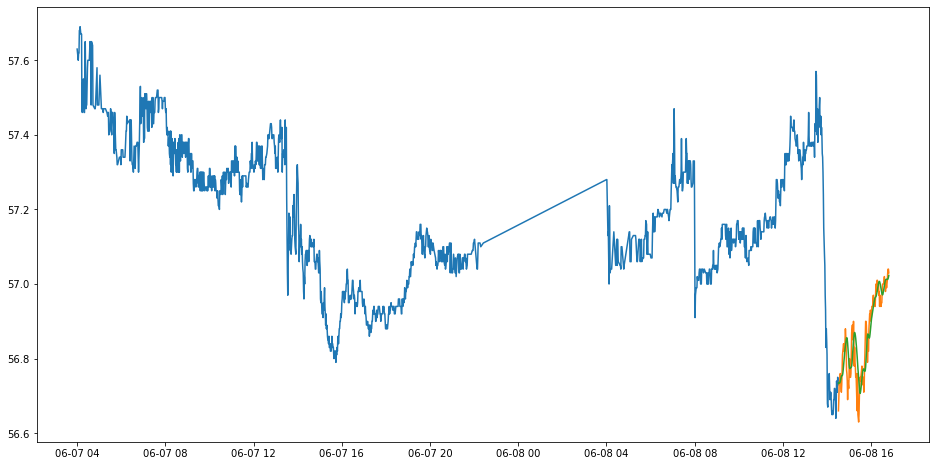

In [17]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = GRU_predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

Real prediiction with LSTM

[0.8773584905660385, 0.7924528301886795, 0.7264150943396217, 0.7924528301886795, 0.7075471698113205, 0.7264150943396217, 0.7830188679245254, 0.75471698113207, 0.8018867924528266, 0.8207547169811278, 0.7452830188679229, 0.7452830188679229, 0.7735849056603783, 0.7264150943396217, 0.7452830188679229, 0.7264150943396217, 0.6792452830188651, 0.669811320754718, 0.6320754716981085, 0.5754716981132049, 0.49056603773584584, 0.4528301886792434, 0.42452830188678803, 0.39622641509433265, 0.3207547169811278, 0.28301886792452535, 0.18867924528301216, 0.23584905660376876, 0.2075471698113205, 0.16981132075471095, 0.04716981132074949, 0.03773584905660243, 0.08490566037735192, 0.09433962264149898, 0.10377358490566024, 0.12264150943395435, 0.08490566037735192, 0.056603773584896544, 0.0660377358490507, 0.07547169811320487, 0.0660377358490507, 0.03773584905660243, 0.01886792452829411, 0.028301886792441167, 0.01886792452829411, 0.01886792452829411, 0.028301886792441167, 0.056603773584896544, 0.0566037735848

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



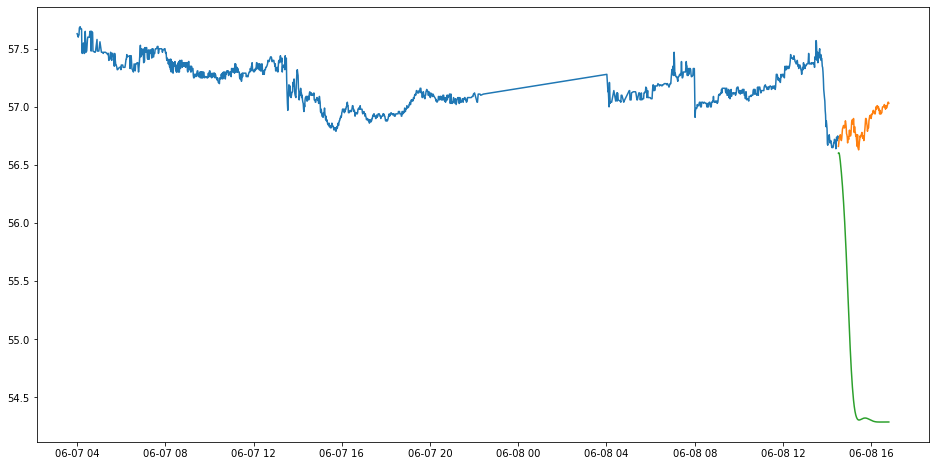

In [18]:
from numpy import array
x_input=scaled_data[splitter-60:splitter,:].reshape(1,-1)

temp_input1=list(x_input)
temp_input1=temp_input1[0].tolist()
print((temp_input1))
temp2=np.array(temp_input1)
lst_output1=[]
n_steps1=60
i=0
while(i<len(scaled_data)-splitter):
    
    if(len(temp_input1)>60):
        #print(temp_input)
        x_input=np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps1, 1))
        #print(x_input)
        yhat1 = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat1))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1=temp_input1[1:]
        #print(temp_input)
        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps1,1))
        yhat1 = model.predict(x_input, verbose=0)
        print(yhat1[0])
        temp_input1.extend(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1
    

print("lst:", lst_output1)
predictions = scaler.inverse_transform(lst_output1)

from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], predictions, squared=False)
print(r2_score(valid["Close"],predictions))
rms
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [19]:
from numpy import array
x_input=scaled_data[splitter-60:splitter,:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print((temp_input))
temp2=np.array(temp_input)
# print(scaler.inverse_transform(temp2.reshape(-1,1)))

[0.8773584905660385, 0.7924528301886795, 0.7264150943396217, 0.7924528301886795, 0.7075471698113205, 0.7264150943396217, 0.7830188679245254, 0.75471698113207, 0.8018867924528266, 0.8207547169811278, 0.7452830188679229, 0.7452830188679229, 0.7735849056603783, 0.7264150943396217, 0.7452830188679229, 0.7264150943396217, 0.6792452830188651, 0.669811320754718, 0.6320754716981085, 0.5754716981132049, 0.49056603773584584, 0.4528301886792434, 0.42452830188678803, 0.39622641509433265, 0.3207547169811278, 0.28301886792452535, 0.18867924528301216, 0.23584905660376876, 0.2075471698113205, 0.16981132075471095, 0.04716981132074949, 0.03773584905660243, 0.08490566037735192, 0.09433962264149898, 0.10377358490566024, 0.12264150943395435, 0.08490566037735192, 0.056603773584896544, 0.0660377358490507, 0.07547169811320487, 0.0660377358490507, 0.03773584905660243, 0.01886792452829411, 0.028301886792441167, 0.01886792452829411, 0.01886792452829411, 0.028301886792441167, 0.056603773584896544, 0.0566037735848

In [20]:
lst_output=[]
n_steps=60
i=0
while(i<len(scaled_data)-splitter):
    
    if(len(temp_input)>60):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = my_GRU_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = my_GRU_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    



[0.09778756]
61
1 day input [0.79245283 0.72641509 0.79245283 0.70754717 0.72641509 0.78301887
 0.75471698 0.80188679 0.82075472 0.74528302 0.74528302 0.77358491
 0.72641509 0.74528302 0.72641509 0.67924528 0.66981132 0.63207547
 0.5754717  0.49056604 0.45283019 0.4245283  0.39622642 0.32075472
 0.28301887 0.18867925 0.23584906 0.20754717 0.16981132 0.04716981
 0.03773585 0.08490566 0.09433962 0.10377358 0.12264151 0.08490566
 0.05660377 0.06603774 0.0754717  0.06603774 0.03773585 0.01886792
 0.02830189 0.01886792 0.01886792 0.02830189 0.05660377 0.05660377
 0.08490566 0.08490566 0.06603774 0.05660377 0.00943396 0.04716981
 0.10377358 0.08490566 0.0754717  0.11320755 0.09433962 0.09778756]
1 day output [[0.10313103]]
2 day input [0.72641509 0.79245283 0.70754717 0.72641509 0.78301887 0.75471698
 0.80188679 0.82075472 0.74528302 0.74528302 0.77358491 0.72641509
 0.74528302 0.72641509 0.67924528 0.66981132 0.63207547 0.5754717
 0.49056604 0.45283019 0.4245283  0.39622642 0.32075472 0.283

In [21]:
# print(lst_output)
predictions = scaler.inverse_transform(lst_output)
# print(predictions)
# lst_output=np.array(predictions)
# print(predictions.shape)
# print((lst_output))
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(valid["Close"], predictions, squared=False)
print(r2_score(valid["Close"],predictions))
rms

-0.2787491049026396


0.12614461031547777

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



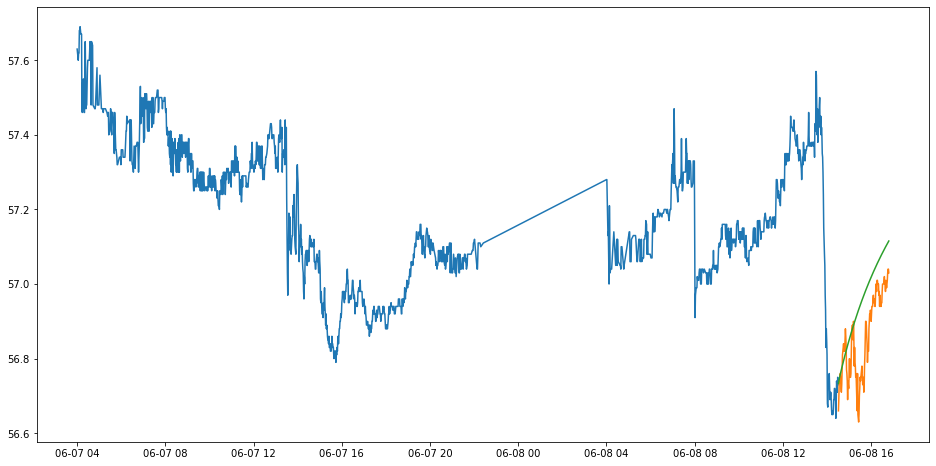

In [22]:
#for plotting
train = new_data[:splitter]
valid = new_data[splitter:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])